In [1]:
from utils.molec_class_files import r14, r32, r50, r125, r134a, r143a, r170, r41, r23, r161, r152a, r152, r134, r143, r116
from utils import atom_type, opt_atom_types
import numpy as np
import unyt as u
import pandas as pd
from fffit.fffit.utils import values_real_to_scaled, values_scaled_to_real, variances_scaled_to_real, generate_lhs
from fffit.fffit.plot import plot_obj_contour
import os

#Load class properies for each molecule
r14_class = r14.R14Constants()
r32_class = r32.R32Constants()
r50_class = r50.R50Constants()
r125_class = r125.R125Constants()
r134a_class = r134a.R134aConstants()
r143a_class = r143a.R143aConstants()
r170_class = r170.R170Constants()

r41_class = r41.R41Constants()
r23_class = r23.R23Constants()
r161_class = r161.R161Constants()
r152a_class = r152a.R152aConstants()
r152_class = r152.R152Constants()
r143_class = r143.R143Constants()
r134_class = r134.R134Constants()
r116_class = r116.R116Constants()

2024-10-15 15:12:17.063891: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 15:12:17.110059: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 15:12:17.110112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 15:12:17.112103: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 15:12:17.120823: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 15:12:17.121418: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [165]:
def calc_fxn(theta_guess, setup):
    """
    Calculates the sse objective function

    Parameters
    ----------
    theta_guess: np.ndarray, the atom type scheme parameter set to start optimization at (sigma in nm, epsilon in kJ/mol)

    Returns
    -------
    obj: float, the objective function value
    sse_pieces: dict, dictionary of sse values for each property
    mean_wt_pieces: dict, dictionary of mean weights for each property
    """
    #  = setups
    assert isinstance(theta_guess, np.ndarray), "theta_guess must be an np.ndarray"
    # Initialize weight and squared error arrays
    mean_array = []
    # var_array = []
    # var_theta = []

    # Unscale data from 0 to 1 to get correct objective values
    at_bounds_pref = setup.at_class.at_bounds_nm_kjmol
    theta_guess = values_scaled_to_real(theta_guess.reshape(1, -1), at_bounds_pref)

    # Loop over molecules
    for molec in list(setup.molec_data_dict.keys()):
        # Get constants for molecule
        molec_object = setup.molec_data_dict[molec]
        # Get theta associated with each gp
        param_matrix = setup.at_class.get_transformation_matrix(
            {molec: molec_object}
        )
        # Transform the guess, and scale to bounds
        gp_theta = theta_guess.reshape(-1, 1).T @ param_matrix
        gp_theta_guess = values_real_to_scaled(gp_theta, molec_object.param_bounds)
        # Get GPs associated with each molecule
        molec_gps_dict = setup.all_gp_dict[molec]

        # Loop over gps (1 per property)
        for key in list(molec_gps_dict.keys()):
            # Get GP associated with property
            gp_model = molec_gps_dict[key]
            # Get X and Y data and bounds associated with the GP
            exp_data, y_bounds, y_names = setup.get_exp_data(molec_object, key)
            # Get x and y data
            x_exp = np.array(list(exp_data.keys())).reshape(-1, 1)
            y_exp = np.array(list(exp_data.values()))
            # #Evaluate GP
            gp_mean_scl, gp_covar_scl, gp_var_scl = setup.eval_gp_new_theta(
                gp_theta_guess, molec_object, gp_model, x_exp
            )
            # Scale gp output to real value
            # gp_mean = values_scaled_to_real(gp_mean_scl, y_bounds)
            # Get y data uncertainties
            # unc = molec_object.uncertainties[key.replace("sim", "expt")]
            # y_var_unc = (y_exp*unc)**2
            # y_var_2pct = (y_exp*0.02)**2
            # y_var = np.maximum(y_var_unc, y_var_2pct)
            # y_std =np.sqrt(y_var)
            # gp_mean_y_scl = gp_mean_scl.flatten()/gp_var_scl.flatten()
            # Scale gp_variances to real values
            # y_bounds_2D = np.asarray(y_bounds).reshape(-1,2)
            # gp_covar = gp_covar_scl * (y_bounds_2D[:, 1] - y_bounds_2D[:, 0]) ** 2
            # gp_var = variances_scaled_to_real(gp_var_scl, y_bounds)
            # mean_array += list(gp_mean_y_scl)
            # No scaling necessary since we are using the scaled values (between 0 and 1) for the objectives and parameters
            mean_array += list(gp_mean_scl)
            # mean_array += list(gp_mean)
            # var_array += list(gp_var.flatten())
    # print("mean array", mean_array)
    return np.array(mean_array)

def calc_fxn_var(theta_guess, setup):
    """
    Calculates the sse objective function

    Parameters
    ----------
    theta_guess: np.ndarray, the atom type scheme parameter set to start optimization at (sigma in nm, epsilon in kJ/mol)

    Returns
    -------
    obj: float, the objective function value
    sse_pieces: dict, dictionary of sse values for each property
    mean_wt_pieces: dict, dictionary of mean weights for each property
    """
    assert isinstance(theta_guess, np.ndarray), "theta_guess must be an np.ndarray"
    # Initialize weight and squared error arrays
    mean_array = []
    var_array = []
    # var_theta = []

    # Unscale data from 0 to 1 to get correct objective values
    at_bounds_pref = setup.at_class.at_bounds_nm_kjmol
    theta_guess = values_scaled_to_real(theta_guess.reshape(1, -1), at_bounds_pref)

    # Loop over molecules
    for molec in list(setup.molec_data_dict.keys()):
        # Get constants for molecule
        molec_object = setup.molec_data_dict[molec]
        # Get theta associated with each gp
        param_matrix = setup.at_class.get_transformation_matrix(
            {molec: molec_object}
        )
        # Transform the guess, and scale to bounds
        gp_theta = theta_guess.reshape(-1, 1).T @ param_matrix
        gp_theta_guess = values_real_to_scaled(gp_theta, molec_object.param_bounds)
        # Get GPs associated with each molecule
        molec_gps_dict = setup.all_gp_dict[molec]

        # Loop over gps (1 per property)
        for key in list(molec_gps_dict.keys()):
            # Get GP associated with property
            gp_model = molec_gps_dict[key]
            # Get X and Y data and bounds associated with the GP
            exp_data, y_bounds, y_names = setup.get_exp_data(molec_object, key)
            # Get x and y data
            x_exp = np.array(list(exp_data.keys())).reshape(-1, 1)
            y_exp = np.array(list(exp_data.values()))
            # #Evaluate GP
            gp_mean_scl, gp_covar_scl, gp_var_scl = setup.eval_gp_new_theta(
                gp_theta_guess, molec_object, gp_model, x_exp
            )
            # Scale gp output to real value
            # gp_mean = values_scaled_to_real(gp_mean_scl, y_bounds)
            # Get y data uncertainties
            # unc = molec_object.uncertainties[key.replace("sim", "expt")]
            # y_var_unc = (y_exp*unc)**2
            # y_var_2pct = (y_exp*0.02)**2
            # y_var = np.maximum(y_var_unc, y_var_2pct)
            # y_std =np.sqrt(y_var)
            # gp_mean_y_scl = gp_mean_scl.flatten()/gp_var_scl.flatten()
            # Scale gp_variances to real values
            # y_bounds_2D = np.asarray(y_bounds).reshape(-1,2)
            # gp_covar = gp_covar_scl * (y_bounds_2D[:, 1] - y_bounds_2D[:, 0]) ** 2
            # gp_var = variances_scaled_to_real(gp_var_scl, y_bounds)
            # mean_array += list(gp_mean_y_scl)
            # No scaling necessary since we are using the scaled values (between 0 and 1) for the objectives and parameters
            mean_array += list(gp_mean_scl)
            # mean_array += list(gp_mean)
            var_array += list(gp_var_scl.flatten())

    return np.array(mean_array), np.array(var_array)

In [158]:
import copy as copy
repeats = 1
seed =1
#Get obj from a set of parameters
at_class = 0
obj_choice = "ExpVal"
molec_names = ["R14", "R32", "R50", "R170", "R125", "R134a", "R143a", "R41"]
setup = opt_atom_types.Opt_ATs(molec_names, at_class, repeats, seed, obj_choice)
all_molec_dir = setup.use_dir_name
path_best_sets = os.path.join(all_molec_dir, "unique_best_set.csv")
all_df = pd.read_csv(path_best_sets, header = 0)
first_param_name = setup.at_class.at_names[0]
last_param_name = setup.at_class.at_names[-1]
best_set = all_df.loc[0, first_param_name:last_param_name].values
best_real = setup.values_pref_to_real(copy.copy(best_set))
# rank_parameters, n_data = setup.rank_parameters(best_real)

In [159]:
#Print the parameter name asociated with each index of rank_parameters
# rank_parameters_names = [setup.at_class.at_names[i] for i in rank_parameters]
# print(rank_parameters_names)
# print(n_data)

In [160]:
# opt_num_params, rcc, loss_k, loss_k_params = setup.estimate_opt(theta_guess, rank_parameters, n_data)
# print("Optimal number of parameters: ", opt_num_params)
# print("RCC: ", rcc)
# print("Best Param Set: ", loss_k_params[opt_num_params-1])

In [161]:
import numpy as np
import numdifftools as nd
at_bounds_real = setup.at_class.at_bounds_nm_kjmol
theta_guess = values_real_to_scaled(best_real.reshape(1, -1), at_bounds_real)
print(best_real)
# fun = lambda x: setup.calc_fxn(x)
fun = calc_fxn
dfun = nd.Gradient(fun)
gradient = dfun(theta_guess, setup)

[0.33638335 0.23361988 0.29372057 0.43617045 0.09213445 0.22085788]


In [170]:
# print(gradient)
gp_means, gp_vars = calc_fxn_var(theta_guess, setup)
# print(np.sqrt(gp_vars))
# print(gp_means.flatten())

def scale_jacobian_by_x_over_F(jacobian, x, F):
    m, n = jacobian.shape  # m = len(F), n = len(x)
    scaled_jacobian = np.zeros_like(jacobian)
    # print(x[0], F[0])
    for i in range(m):
        for j in range(n):
            # print(x[j] / F[i], jacobian[i, j])
            scaled_jacobian[i, j] = (x[j]/ F[i]) * jacobian[i, j]
    
    return scaled_jacobian

gradient_scl = scale_jacobian_by_x_over_F(gradient, theta_guess.flatten(), gp_means.flatten())
print(gradient_scl[0])
#No scl in Jac and not div by var in calc_fxn
# [  53.35921261    0.         -231.64743169   19.24494525    0.
#    26.41865749]
#No scl in Jac and div by var in calc_fxn
# [-7.72691700e+04  0.00000000e+00  3.12585519e-01 -3.44453649e+04
#   0.00000000e+00 -1.27119840e+04]
#No scl in Jac and mult by best_real/F
# [ 0.48310337  0.         -2.09728833  0.17423979  0.          0.23918911]
# Scl Jac and do not add a scaling factor
# [ 0.91011492  0.         -4.52495685  0.684068    0.          0.99859955]
#Scl Jac and use variance scaling factors
# [  43.26794564    0.         -147.82845726   31.15278785    0.
#    23.0004452 ]
#Scl Jac and use value scaling factors
#[ 0.59169765  0.         -2.02158317  0.42602049  0.          0.3145356 ]

[ 0.59169765  0.         -2.02158317  0.42602049  0.          0.3145356 ]


In [163]:
# print(gradient.shape)
# print(theta_guess)
# print(gradient[0])

gradient_scl = gradient#*(0.5*theta_guess)
print(gradient_scl[0])
# print(gradient_scl.shape)

[ 0.91011492  0.         -4.52495685  0.684068    0.          0.99859955]


In [171]:
import numpy as np
from numpy.linalg import norm
from scipy.linalg import lstsq

def rank_parameters(Z):
    # Step 1: Calculate the magnitude of each column in Z
    column_magnitudes = norm(Z, axis=0)
    
    # Initialize variables
    ranked_indices = []  # To keep track of ranked parameter indices
    k = 1
    n, m = Z.shape

    while k <= m:
        if k == 1:
            # Step 2: Identify the most estimable parameter
            max_index = np.argmax(column_magnitudes)
            ranked_indices.append(max_index)
        else:
            # Step 3: Build X_k with the k most estimable columns
            X_k = Z[:, ranked_indices]

            # Predict Z using ordinary least-squares
            Z_hat, _, _, _ = lstsq(X_k, Z)

            # Calculate the residual matrix R_k
            R_k = Z - X_k @ Z_hat

            # Step 4: Calculate the magnitude of each column in R_k
            residual_magnitudes = norm(R_k, axis=0)

            # Step 5: Determine the next most estimable parameter
            # Ensure we pick a column that hasn't been ranked yet
            for idx in np.argsort(-residual_magnitudes):
                if idx not in ranked_indices:
                    ranked_indices.append(idx)
                    break
        
        k += 1  # Step 6: Increase k and repeat

    return ranked_indices

# Example usage
Z = gradient_scl
ranked_params = rank_parameters(Z)
print("Ranked parameters (indices):", ranked_params)
value = [setup.at_class.at_names[param] for param in ranked_params]
print(value)

Ranked parameters (indices): [0, 4, 2, 5, 1, 3]
['sigma_C', 'epsilon_H', 'sigma_F', 'epsilon_F', 'sigma_H', 'epsilon_C']


[1.56080000e+00 8.35460000e+00 8.20000000e-03 8.60000000e-03
 0.00000000e+00 1.31000000e-02 2.79356378e-07 2.79356378e-07
 0.00000000e+00 0.00000000e+00]
[1.56080000e+00 8.35457894e+00 8.20002258e-03 8.59997832e-03
 2.10624008e-05 1.30789159e-02 2.79356378e-07 2.79356378e-07
 0.00000000e+00 0.00000000e+00]
[1.56079999e+00 8.35427266e+00 8.20035088e-03 8.59966308e-03
 3.27323958e-04 1.27723391e-02 2.79356378e-07 2.79356378e-07
 0.00000000e+00 0.00000000e+00]
[1.56079999e+00 8.35411823e+00 8.20050113e-03 8.59950409e-03
 4.81761361e-04 1.26177427e-02 2.79356378e-07 2.79356378e-07
 0.00000000e+00 0.00000000e+00]
[1.56079993e+00 8.35335212e+00 8.20135271e-03 8.59871562e-03
 1.24781090e-03 1.18509047e-02 2.79356378e-07 2.79356378e-07
 0.00000000e+00 0.00000000e+00]
[1.56079979e+00 8.35321689e+00 8.20162966e-03 8.59857673e-03
 1.38290497e-03 1.17156718e-02 2.79356378e-07 2.79356378e-07
 0.00000000e+00 0.00000000e+00]
[1.56079980e+00 8.35305570e+00 8.20178816e-03 8.59841079e-03
 1.54410555e-03

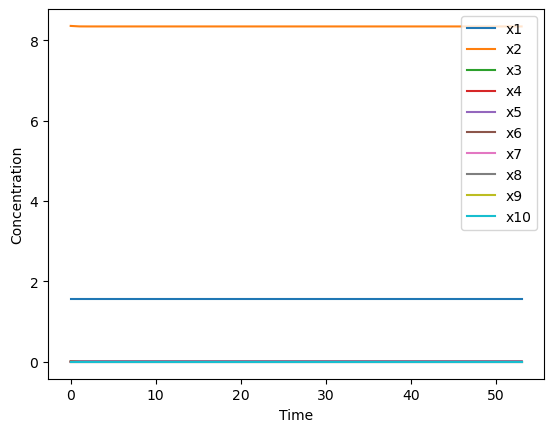

In [202]:
#Model
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define parameters
K1, K2, K3 = 3*1e-16, 5*1e-14, 2*1e-16 # constants for x8, x9, x10 equations
E1, E2, E_L1 = 1e4, 1e4, 1e4  # activation energies (example values)
R = 1.986  # Gas constant (J/(mol*K))
T, T0 = 313.15, 340.15  # Temperature (K)

# Define the reaction rate constants as functions of temperature
def k1(T):
    k10 = 1.0  # Example pre-exponential factor
    return k10 * np.exp(-E1 / R * (1/T - 1/T0))

def k2(T):
    k20 = 2.0  # Example pre-exponential factor
    return k20 * np.exp(-E2 / R * (1/T - 1/T0))

def k_1(T):
    k_10 = 2000.0  # Example pre-exponential factor
    return k_10 * np.exp(-E_L1 / R * (1/T - 1/T0))

# Define the ODE system
def system(t, X, T):
    x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = X
    print(X)
    
    x7 = -0.0131 + x6 + x8 + x9 + x10
    x8 = (K2 * x1) / (K2 + x7)
    x9 = (K3 * x3) / (K3 + x7)
    x10 = (K1 * x5) / (K1 + x7)

    # Reaction rate constants at current temperature
    k1_val = k1(T)
    k2_val = k2(T)
    k_1_val = k_1(T)
    
    # Define the differential equations
    dx1dt = -k2_val * x2 * x8
    dx2dt = -k1_val * x2 * x6 + k_1_val * x10 - k2_val * x2 * x8
    dx3dt = k2_val * x2 * x8 + k1_val * x4 * x6 - 0.5 * k_1_val * x9
    dx4dt = -k1_val * x4 * x6 + 0.5 * k_1_val * x9
    dx5dt = k1_val * x2 * x6 - k_1_val * x10
    dx6dt = -k1_val * x2 * x6 + k_1_val * x10 - k1_val * x4 * x6 + 0.5 * k_1_val * x9
    
    
    return np.array([dx1dt, dx2dt, dx3dt, dx4dt, dx5dt, dx6dt,0,0,0,0])

# Initial conditions
x1 = 1.5608
x70 = 0.5*(-K2+(K2**2+4*K2*x1)**0.5)
X0 = [x1, 8.3546, 0.0082, 0.0086, 0.0, 0.0131, x70, x70, 0.0, 0.0]  # Example initial conditions

# Time span for the simulation
t_span = (0, 53)  # Time range in arbitrary units
t_eval = np.linspace(0, 53, 53)

# Solve the system of ODEs
solution = solve_ivp(system, t_span, X0, args=(T,), t_eval=t_eval, method='RK45', dense_output=True)
print(solution.y.shape)
# Plot the results
plt.plot(solution.t, solution.y.T)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend([f'x{i+1}' for i in range(10)])
plt.show()
